In [1]:
# install sompy
# !conda install git
# !pip install -U git+https://github.com/sevamoo/SOMPY.git
# !pip install scikit-image
# IF THIS IT TAKING TOO LONG, TRY TO INSTALL IT FROM THE ANACONDA PROMPT

In [2]:
from IPython.display import YouTubeVideo

from os.path import join
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier

import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

In [3]:
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib import colors as mpl_colors

from matplotlib.lines import Line2D
from matplotlib import __version__ as mplver


## Import preprocessed data

In [4]:
df = pd.read_csv(join('..', 'data', 'tugas_preprocessed.csv'))

In [5]:
df.head()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,...,x_status_Widow,x_gender_M,x_dependents_1.0,x_description_Kind of OK,x_description_Meh...,x_description_OK nice!,x_description_Take my money!!,PC0,PC1,PC2
0,0.743162,1.191605,0.457819,-0.617023,-0.243065,1.216847,0.495837,-0.499274,-1.257560,0.522055,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.896356,1.937697,-1.120781
1,1.559488,1.100011,-1.535723,0.166160,-0.790228,0.740464,-0.374374,-0.631907,-1.798649,-0.237578,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.981092,1.421498,-0.785625
2,-1.548542,-0.823463,0.557496,-0.834573,1.672006,-0.371096,-0.809480,2.286023,0.906799,-0.904191,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,-2.813108,-0.381440,0.780867
3,0.845528,0.550447,-1.402820,0.383710,0.440889,-0.768082,-0.084304,-0.234007,-0.391816,0.785568,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.247013,0.514177,1.302203
4,0.782435,1.008417,-0.871209,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,-0.445925,1.237135,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.781920,0.704805,0.443376


In [6]:
df.columns

Index(['income', 'frq', 'rcn', 'clothes', 'kitchen', 'small_appliances',
       'toys', 'house_keeping', 'per_net_purchase', 'spent_online',
       'x_education_2nd Cycle', 'x_education_Graduation', 'x_education_Master',
       'x_education_PhD', 'x_status_Married', 'x_status_Single',
       'x_status_Together', 'x_status_Widow', 'x_gender_M', 'x_dependents_1.0',
       'x_description_Kind of OK', 'x_description_Meh...',
       'x_description_OK nice!', 'x_description_Take my money!!', 'PC0', 'PC1',
       'PC2'],
      dtype='object')

In [7]:
# Splitting feature names into groups
non_metric_features = df.columns[df.columns.str.startswith('x')]
pc_features = df.columns[df.columns.str.startswith('PC')]
metric_features = df.columns[~df.columns.str.startswith('x') & ~df.columns.str.startswith('PC')]

## Self-organizing maps
What is a SOM? How does it work? What is it used for?

The SOM objective is to adjust the units to the data in the input space, so that the
network is (as best as possible) representative of the training dataset.

### How is it computed?
### Important concepts:
- Units and observations
- BMU
- Neighborhood function
- Input and Output space

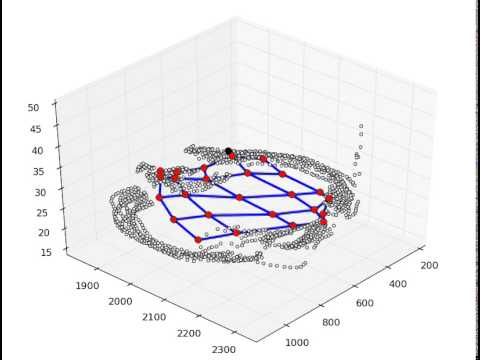

In [8]:
YouTubeVideo('k7DK5fnJH94')

### Characteristics:
- Grid shape needs to be set a priori
- Results depend on the initialization (even tough it can be quite robust to it)
- Fitting a SOM can be computationally expensive
- Capable of finding the global optimum (theoretically - if the LR -> 0)
- Visualization tool for high-dimensional data

### Additional analyses/tutorials
- [Air Flights](https://github.com/sevamoo/SOMPY/blob/master/sompy/examples/AirFlights_hexagonal_grid.ipynb)
- [Visualizations on toy datasets](https://gist.github.com/sevamoo/035c56e7428318dd3065013625f12a11)

### How to apply Self-Organizing Maps?

The training of a SOM is **more effective** if it is done in two phases: the unfolding phase, and the fine-tuning phase. 

In the **unfolding phase** the objective is to **spread the units** in the region of the input space where the data patterns are located. In this phase the neighbourhood function should have a large initial radius so that all units have high mobility and the map can quickly cover the input space.

The **fine tuning phase**, as the name implies, is the process of small adjustments in order to **reduce the quantization error**, and centre the units in the areas where the density of patterns is highest. Usually, in this phase the learning rate and the neighbourhood radius are smaller than the ones used in the unfolding phase. As these two parameters are smaller, the map will need more time to adjust its weights and that is why the number of iterations or epochs is normally higher.

**Exercise**
- Train a SOM with a 10x10 grid, random initialization, gaussian neighborhood function and hexagonal topology/lattice
- Set an unfolding phase and a fine tuning phase of 100 iterations

In [9]:
# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(42)

sm = sompy.SOMFactory().build(
    df[metric_features].values, 
    mapsize=[10, 10],  # NEEDS TO BE A LIST
    initialization='random', 
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=metric_features
)
sm.train(n_job=4, verbose='info', train_rough_len=100, train_finetune_len=100)

 Training...
 random_initialization took: 0.001000 seconds
 Rough training...
 radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.045000, quantization error: 3.682456

 epoch: 2 ---> elapsed time:  0.014000, quantization error: 2.946359

 epoch: 3 ---> elapsed time:  0.010000, quantization error: 2.860489

 epoch: 4 ---> elapsed time:  0.013000, quantization error: 2.808903

 epoch: 5 ---> elapsed time:  0.013000, quantization error: 2.794875

 epoch: 6 ---> elapsed time:  0.014000, quantization error: 2.785167

 epoch: 7 ---> elapsed time:  0.014000, quantization error: 2.776508

 epoch: 8 ---> elapsed time:  0.015000, quantization error: 2.769936

 epoch: 9 ---> elapsed time:  0.012000, quantization error: 2.765027

 epoch: 10 ---> elapsed time:  0.021000, quantization error: 2.760520

 epoch: 11 ---> elapsed time:  0.021000, quantization error: 2.756233

 epoch: 12 ---> elapsed time:  0.030000, quantization error: 2.751891

 epoch: 13 ---> 

## Visualizing data with SOMs

### Component planes
What do they represent? What kinds of information do they contain?

Analyse these plots from the following perspectives:
- Feature importance
- Feature correlation (both globally and locally)
- Data distribution
- Outlier detection

In [10]:
sm

In [11]:
len(metric_features)

10

In [12]:
plt.rcParams['figure.dpi'] = 72

In [13]:
weights = sm.codebook.matrix 

In [14]:
###################################
### Visualizing Component Planes ##
###################################

def plot_component_planes(weights,
                          features,
                          M=3, N=4, 
                          figsize=(20,20),
                          figlayout=(3,4),
                          title="Component Planes",
                          cmap=cm.magma
                         ):
    
    xx, yy = np.meshgrid(np.arange(M), np.arange(N))
    xx = xx.astype(float)
    yy = yy.astype(float)

    xx[::-2] -= 0.5

    xx = xx.T
    yy = yy.T
    
    weights_ = weights.reshape((M,N,len(features)))

    fig = plt.figure(figsize=figsize, constrained_layout=True)
    subfigs = fig.subfigures(figlayout[0], figlayout[1], wspace=.15)
    
    ## Normalize color scale to range of all values
    colornorm = mpl_colors.Normalize(vmin=np.min(weights), 
                                         vmax=np.max(weights))

    for cpi, sf in zip(range(len(metric_features)), subfigs.flatten()):

        sf.suptitle(features[cpi], y=0.95)

        axs = sf.subplots(1,1, )
        axs.set_aspect('equal')

        ## Normalize color scale to range of values in each component
        colornorm = mpl_colors.Normalize(vmin=np.min(weights_[:,:,cpi]), 
                                         vmax=np.max(weights_[:,:,cpi]))

        # iteratively add hexagons
        for i in range(weights_.shape[0]):
            for j in range(weights_.shape[1]):
                wy = yy[(i, j)] * np.sqrt(3) / 2
                hexagon = RegularPolygon((xx[(i, j)], wy), 
                                     numVertices=6, 
                                     radius=.99 / np.sqrt(3),
                                     facecolor=cmap(colornorm(weights_[i, j, cpi])), 
                                     alpha=1, 
                                     linewidth=.5,
                                     edgecolor=cmap(colornorm(weights_[i, j, cpi]))
                                    )
                axs.add_patch(hexagon)


        ## only run this block if matplotlib >= 3.6.x
        mplv = [int(i) for i in mplver.split('.')]
        if mplv[1] >= 6:
            ## Add colorbar
            divider = make_axes_locatable(axs)

            ax_cb = divider.append_axes("right", size="7%")#, pad="2%")

            ## Create a Mappable object
            cmap_sm = plt.cm.ScalarMappable(cmap=cmap, norm=colornorm)
            cmap_sm.set_array([])

            ## Create custom colorbar 
            cb1 = colorbar.Colorbar(ax_cb,
                                    orientation='vertical', 
                                    alpha=1,
                                    mappable=cmap_sm
                                    )
            cb1.ax.get_yaxis().labelpad = 16

            ## Add colorbar to plot
            sf.add_axes(ax_cb)



        ## Remove axes for hex plot
        axs.margins(.05)
        axs.axis("off")


    fig.suptitle(title)
    plt.show()

In [15]:
print("matplotlib version is:" , mplver)

matplotlib version is: 3.4.3


In [16]:
#### Use this if cell below does not work ####

#plot_component_planes(weights=sm.codebook.matrix,features=metric_features,
#                      M=10,N=10,
#                      figsize=(12,15),figlayout=(4,3),
#                      title="Component Planes",
#                      cmap=sns.color_palette("rocket", as_cmap=True))


/opt/homebrew/Caskroom/miniforge/base/envs/dm/lib/python3.9/site-packages/sompy/visualization/plot_tools.py:45: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(shape[0], shape[1], comp + 1, aspect='equal')


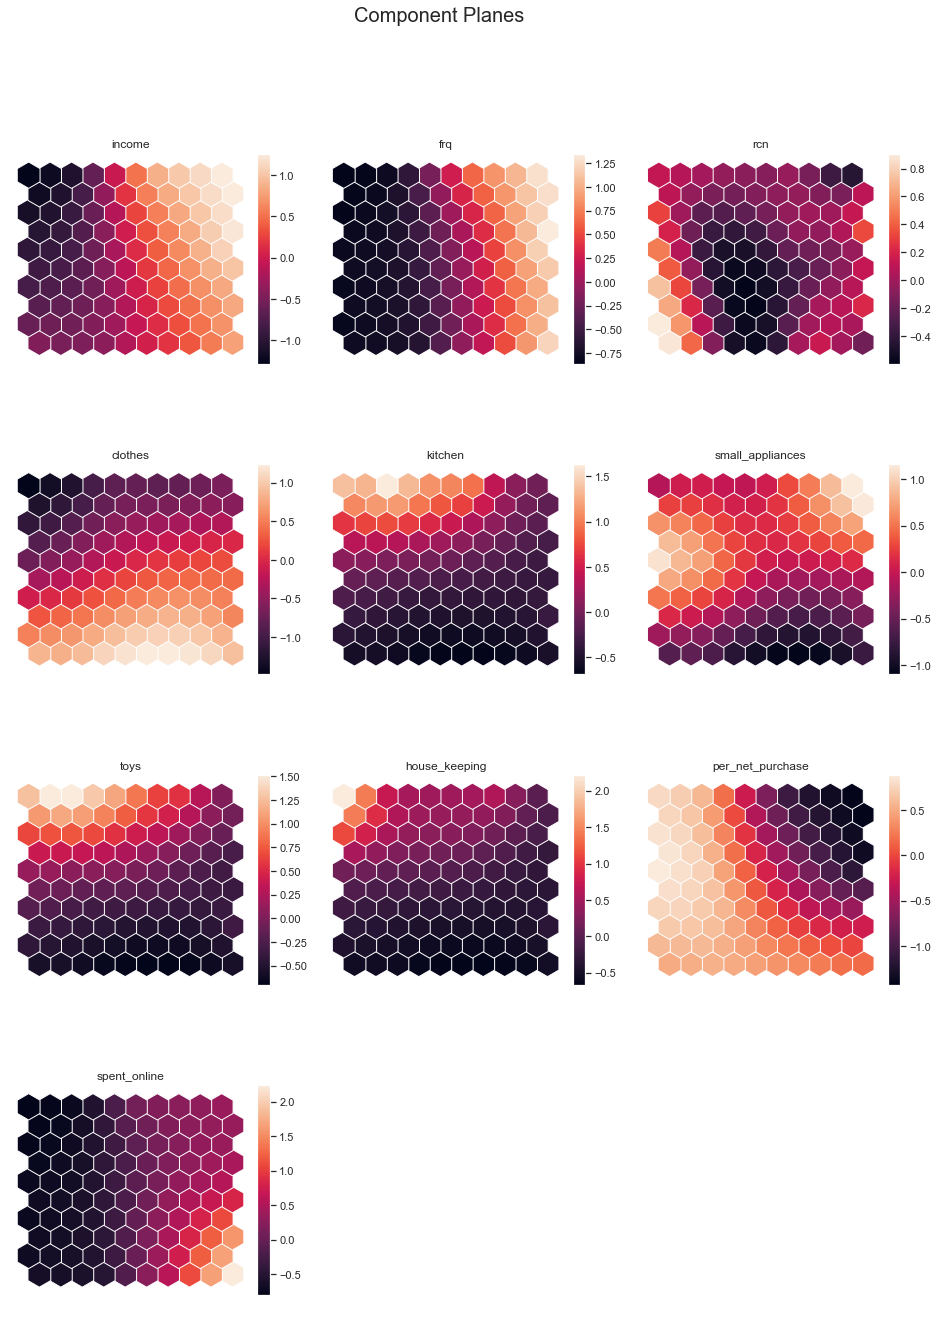

In [17]:
## Run this cell ONLY if matplotlib version is <= 3.4.x
## Comment out this cell and run the cell above instead if it doesn't work.


# Visualizing the Component planes (feature values)
sns.set()
view2D = View2D(12, 12, "", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()

## U-matrix
Encode each neuron in the output space with the **average distance** to its neighbors in the input space.

Analyse these plots from the following perspectives:
- Clusters of units
- Pontential outliers (units which are very distant from its neighbors and have low frequency)

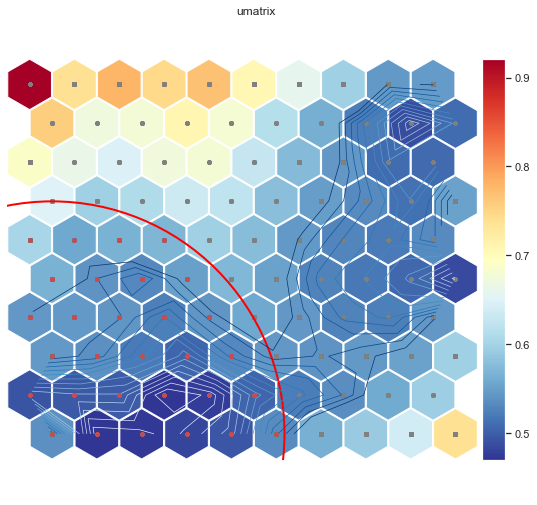

array([[0.92136765, 0.73867804, 0.77952901, 0.74691998, 0.76959171,
        0.70785844, 0.66030454, 0.59631877, 0.54496034, 0.54646589],
       [0.75745679, 0.67246714, 0.67810975, 0.70877988, 0.68130679,
        0.61564947, 0.56213646, 0.52222167, 0.48786457, 0.50966936],
       [0.68943785, 0.66292   , 0.64752789, 0.67417131, 0.67961841,
        0.62884713, 0.57582766, 0.54342626, 0.50940243, 0.50837397],
       [0.64944586, 0.59645678, 0.60963036, 0.63578285, 0.62340446,
        0.57795369, 0.548868  , 0.53244865, 0.51376994, 0.55306676],
       [0.60298068, 0.55755917, 0.56644452, 0.57047415, 0.59587306,
        0.57717231, 0.5453387 , 0.52927266, 0.52088217, 0.53345993],
       [0.56606908, 0.54064812, 0.53036828, 0.55016002, 0.57142378,
        0.55191687, 0.52701242, 0.51848967, 0.50673626, 0.48486911],
       [0.54252798, 0.54557884, 0.54129502, 0.5240497 , 0.54180638,
        0.55749946, 0.54425635, 0.52830235, 0.52320438, 0.54346002],
       [0.54434154, 0.53799738, 0.5202299

In [18]:
# Here you have U-matrix
u = sompy.umatrix.UMatrixView(9, 9, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance=2,
    row_normalized=False,
    show_data=True, 
    contour=True, # Visualize isomorphic curves
    blob=True
)

np.flip(UMAT[1], axis=1) # U-matrix values - they match with the plot colors

### Hit-map
Show the **frequency** of each Unit in the output map

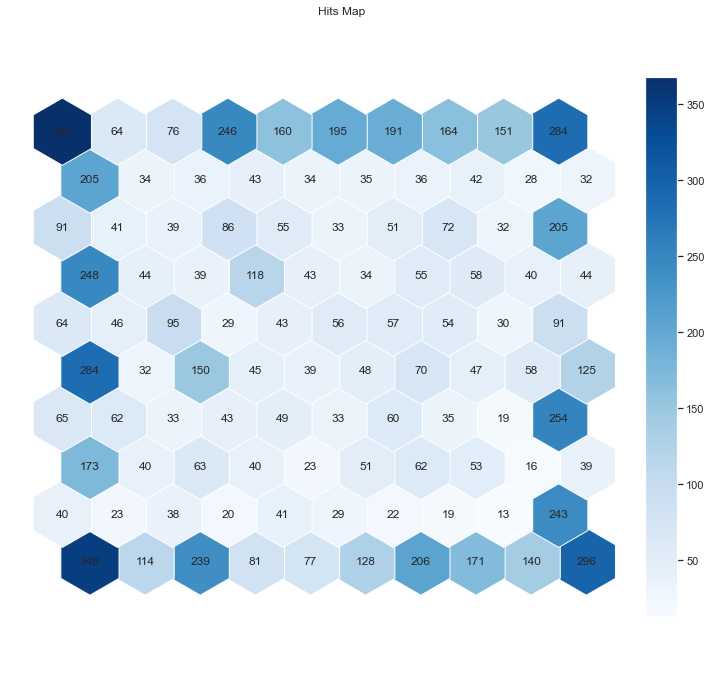

In [19]:
vhts  = BmuHitsView(12,12,"Hits Map")
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=12, cmap="Blues")
plt.show()

## Clustering with SOMs: K-means SOM vs Emergent SOM
- In **k-means SOM**, the *number of units should be equal to the expected number of clusters*, and thus each cluster should be represented by a single unit. 
- In **emergent SOM**, a very *large number of units is used*. These very large SOM allow for very clear U-Matrices and are useful for detecting quite clearly the underlying structure of the data. This technique can be **used together with other clustering algorithms**.

**Exercise**
- Train a SOM with a 50x50 grid, random initialization, gaussian neighborhood function and hexagonal topology/lattice
- Set an unfolding phase and a fine tuning phase of 100 iterations

In [20]:
# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(42)

# Notice that the SOM did not converge - We're under a time constraint for this class
sm = sompy.SOMFactory().build(
    df[metric_features].values, 
    mapsize=[50, 50],  # NEEDS TO BE A LIST
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=metric_features
)
sm.train(n_job=-1, verbose='info', train_rough_len=100, train_finetune_len=100)

 Training...
 random_initialization took: 0.001000 seconds
 Rough training...
 radius_ini: 17.000000 , radius_final: 2.833333, trainlen: 100

 epoch: 1 ---> elapsed time:  6.042000, quantization error: 2.528420

 epoch: 2 ---> elapsed time:  5.313000, quantization error: 3.002704

 epoch: 3 ---> elapsed time:  5.636000, quantization error: 2.970090

 epoch: 4 ---> elapsed time:  4.436000, quantization error: 2.957985

 epoch: 5 ---> elapsed time:  5.278000, quantization error: 2.949119

 epoch: 6 ---> elapsed time:  4.218000, quantization error: 2.944293

 epoch: 7 ---> elapsed time:  4.348000, quantization error: 2.939871

 epoch: 8 ---> elapsed time:  5.300000, quantization error: 2.936053

 epoch: 9 ---> elapsed time:  4.334000, quantization error: 2.932998

 epoch: 10 ---> elapsed time:  4.445000, quantization error: 2.931020

 epoch: 11 ---> elapsed time:  4.408000, quantization error: 2.929364

 epoch: 12 ---> elapsed time:  3.808000, quantization error: 2.927738

 epoch: 13 --->

In [21]:
# Coordinates of the units in the input space
sm.codebook.matrix

array([[-0.172652, -0.409514,  1.217731, ..., -0.752216,  0.806822,
        -0.194723],
       [-0.259466, -0.589575,  1.252261, ..., -0.750917,  0.678894,
        -0.401653],
       [-0.407799, -0.783527,  1.297466, ..., -0.766757,  0.564796,
        -0.622011],
       ...,
       [ 1.387851,  1.521624, -1.102559, ..., -0.317733, -1.522489,
         0.399967],
       [ 1.49386 ,  1.801575, -1.094948, ..., -0.216991, -1.468402,
         0.653752],
       [ 1.583693,  1.983009, -1.060115, ..., -0.061318, -1.384386,
         0.933026]])

In [22]:
#### Use this if cell below does not work

# plot_component_planes(weights=sm.codebook.matrix,features=metric_features,
#                      M=50,N=50,
#                      figsize=(12,15),figlayout=(4,3),
#                      title="Component Planes 50x50",
#                      cmap=sns.color_palette("rocket", as_cmap=True))


/opt/homebrew/Caskroom/miniforge/base/envs/dm/lib/python3.9/site-packages/sompy/visualization/plot_tools.py:45: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(shape[0], shape[1], comp + 1, aspect='equal')


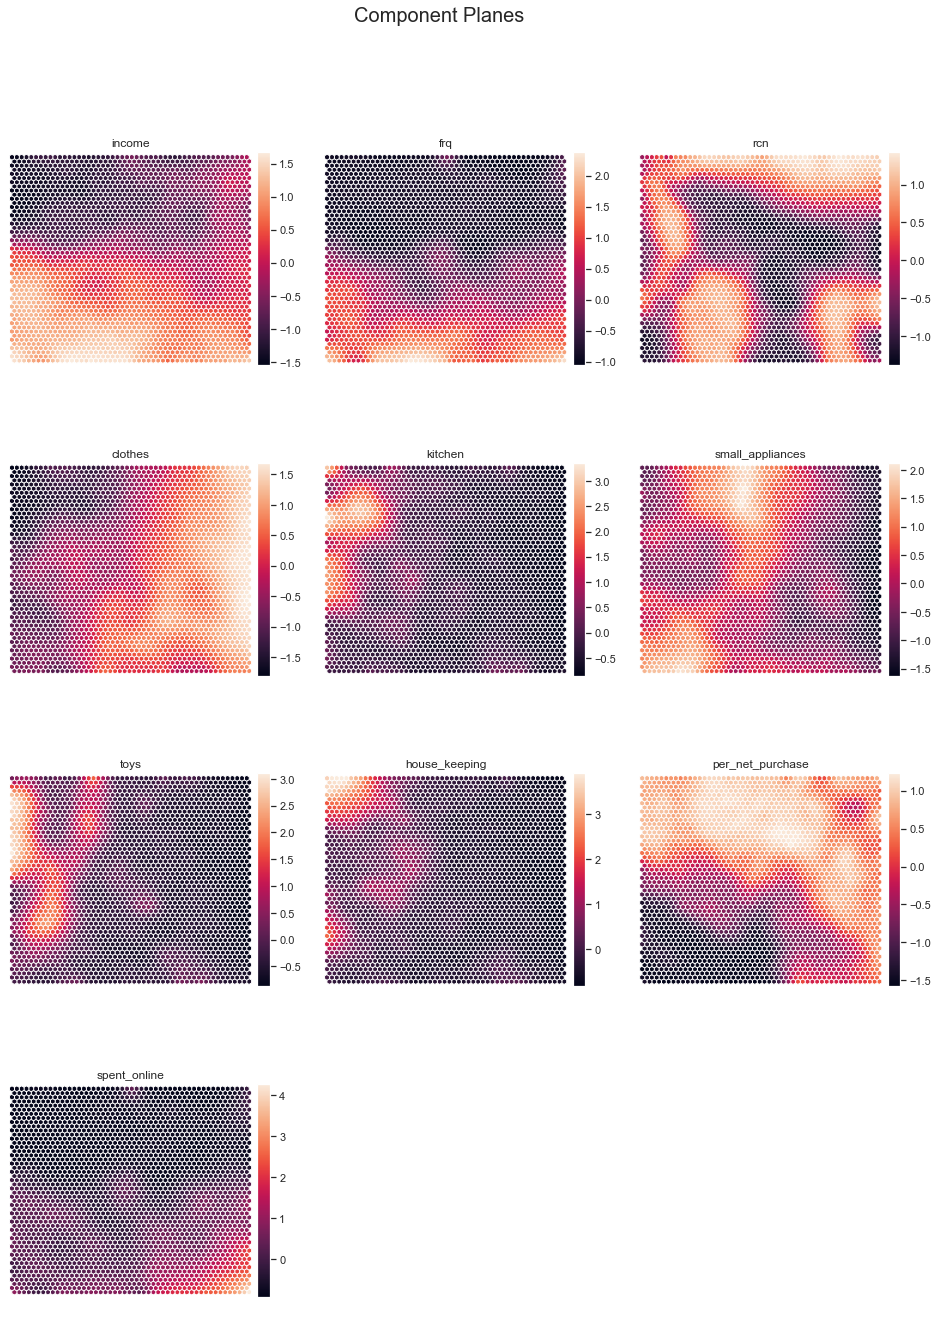

In [23]:
# Component planes on the 50x50 grid
sns.set()
view2D = View2D(12,12,"", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()

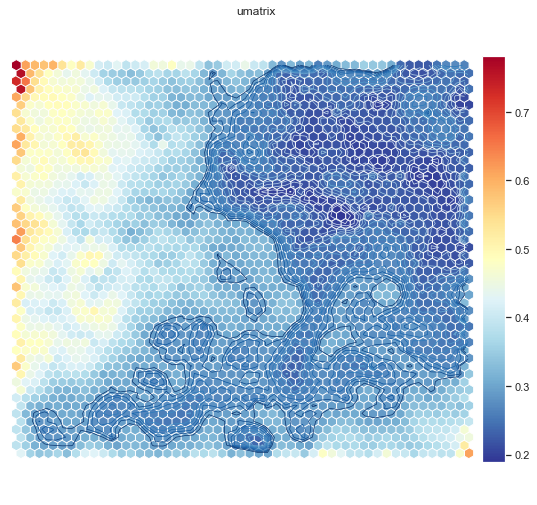

In [24]:
# U-matrix of the 50x50 grid
u = sompy.umatrix.UMatrixView(9, 9, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance=2, 
    row_normalized=False, 
    show_data=False, 
    contour=True # Visualize isomorphic curves
)

Now we can have a better idea of how the input space look like in terms of distances.

### K-Means on top of SOM units
- Define number of clusters to retain

In [25]:
# Do the Inertia plot here (check last class' notebook)

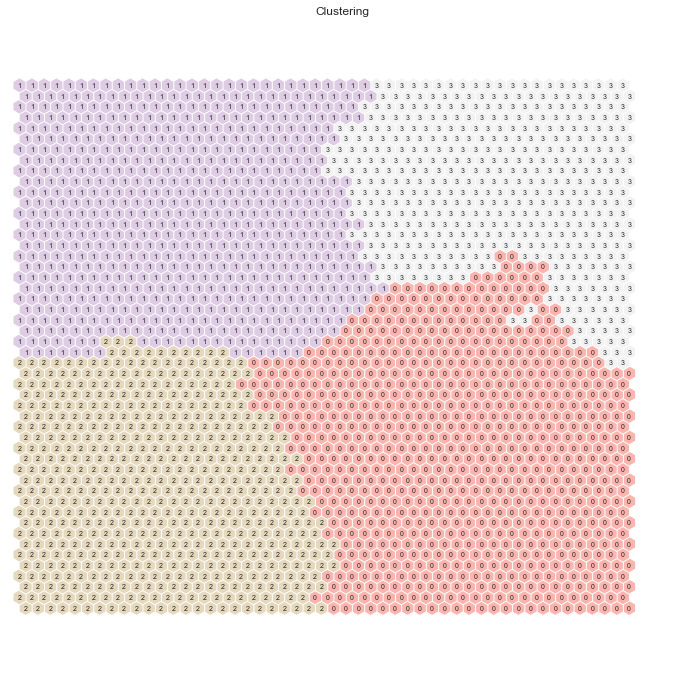

In [26]:
# Perform K-Means clustering on top of the 2500 untis (sm.get_node_vectors() output)
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=20, random_state=42)
nodeclus_labels = kmeans.fit_predict(sm.codebook.matrix)
sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

hits = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

### Hierarchical Clustering on top of SOM units
- Define best linkage method
- Define number of clusters to retain

In [27]:
# Do the R² plot here and the Dendrogram (check last class' notebook)

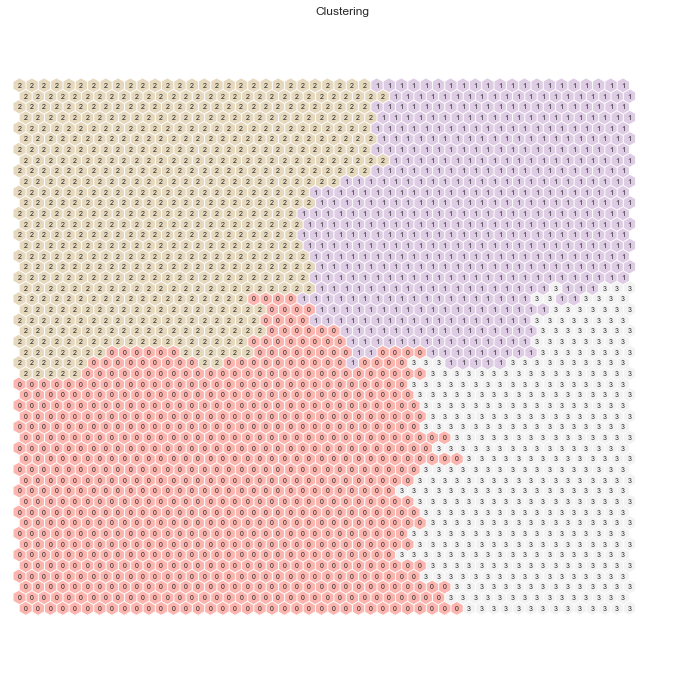

In [28]:
# Perform Hierarchical clustering on top of the 2500 untis (sm.get_node_vectors() output)
hierclust = AgglomerativeClustering(n_clusters=4, linkage='ward')
nodeclus_labels = hierclust.fit_predict(sm.codebook.matrix)
sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

hits  = HitMapView(12, 12,"Clustering",text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

### Final SOM Clustering solution

In [29]:
# Check the nodes and and respective clusters
nodes = sm.codebook.matrix

df_nodes = pd.DataFrame(nodes, columns=metric_features)
df_nodes['label'] = nodeclus_labels
df_nodes

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,label
0,-0.172652,-0.409514,1.217731,1.439077,-0.806891,-1.268857,-0.817977,-0.752216,0.806822,-0.194723,3
1,-0.259466,-0.589575,1.252261,1.484388,-0.801948,-1.356737,-0.809384,-0.750917,0.678894,-0.401653,3
2,-0.407799,-0.783527,1.297466,1.503577,-0.795588,-1.389552,-0.795530,-0.766757,0.564796,-0.622011,3
3,-0.554188,-0.920348,1.330853,1.448093,-0.782427,-1.313648,-0.772917,-0.755390,0.666322,-0.787539,3
4,-0.595590,-0.985265,1.361345,1.327298,-0.746298,-1.152825,-0.735779,-0.720928,0.669144,-0.851696,3
...,...,...,...,...,...,...,...,...,...,...,...
2495,1.114056,0.896375,-0.793772,-0.750298,-0.129896,1.828756,-0.308590,-0.365364,-1.572526,-0.015265,2
2496,1.250219,1.222620,-0.985533,-0.671122,-0.213244,1.722835,-0.314634,-0.339218,-1.567938,0.159299,2
2497,1.387851,1.521624,-1.102559,-0.693538,-0.203164,1.704893,-0.242741,-0.317733,-1.522489,0.399967,2
2498,1.493860,1.801575,-1.094948,-0.755825,-0.175655,1.711758,-0.181039,-0.216991,-1.468402,0.653752,2


In [30]:
# Obtaining SOM's BMUs labels
bmus_map = sm.find_bmu(df[metric_features])[0]  # get bmus for each observation in df

df_bmus = pd.DataFrame(
    np.concatenate((df, np.expand_dims(bmus_map,1)), axis=1),
    index=df.index, columns=np.append(df.columns,"BMU")
)
df_bmus

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,...,x_gender_M,x_dependents_1.0,x_description_Kind of OK,x_description_Meh...,x_description_OK nice!,x_description_Take my money!!,PC0,PC1,PC2,BMU
0,0.743162,1.191605,0.457819,-0.617023,-0.243065,1.216847,0.495837,-0.499274,-1.257560,0.522055,...,1.0,0.0,0.0,0.0,0.0,1.0,0.896356,1.937697,-1.120781,2241.0
1,1.559488,1.100011,-1.535723,0.166160,-0.790228,0.740464,-0.374374,-0.631907,-1.798649,-0.237578,...,0.0,0.0,0.0,0.0,0.0,1.0,1.981092,1.421498,-0.785625,2473.0
2,-1.548542,-0.823463,0.557496,-0.834573,1.672006,-0.371096,-0.809480,2.286023,0.906799,-0.904191,...,1.0,1.0,1.0,0.0,0.0,0.0,-2.813108,-0.381440,0.780867,241.0
3,0.845528,0.550447,-1.402820,0.383710,0.440889,-0.768082,-0.084304,-0.234007,-0.391816,0.785568,...,0.0,1.0,0.0,0.0,1.0,0.0,1.247013,0.514177,1.302203,1720.0
4,0.782435,1.008417,-0.871209,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,-0.445925,1.237135,...,0.0,1.0,0.0,0.0,0.0,1.0,1.781920,0.704805,0.443376,2318.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8812,0.618993,0.458853,-1.701851,0.209670,0.167308,-0.132905,0.205767,-0.764540,0.257492,1.275517,...,1.0,1.0,1.0,0.0,0.0,0.0,1.162525,0.372854,0.982963,2467.0
8813,0.874744,0.733635,-1.701851,0.731791,-0.243065,-0.609288,-0.519409,-0.366640,0.690363,1.865248,...,0.0,1.0,0.0,0.0,0.0,1.0,2.003026,-0.083121,1.428619,2467.0
8814,-0.455617,-0.731869,-1.535723,0.079139,-0.106274,-0.053508,0.060732,-0.101374,1.556107,-0.801266,...,1.0,1.0,0.0,1.0,0.0,0.0,-1.002171,-1.301747,0.423851,818.0
8815,-0.596155,0.825229,0.657173,-0.442982,0.577680,0.581670,-0.809480,0.561792,-0.608252,0.801051,...,1.0,0.0,0.0,0.0,0.0,1.0,0.130573,0.959962,-0.332242,1584.0


In [31]:
# Get cluster labels for each observation
df_final = df_bmus.merge(df_nodes['label'], 'left', left_on="BMU", right_index=True)
df_final

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,...,x_dependents_1.0,x_description_Kind of OK,x_description_Meh...,x_description_OK nice!,x_description_Take my money!!,PC0,PC1,PC2,BMU,label
0,0.743162,1.191605,0.457819,-0.617023,-0.243065,1.216847,0.495837,-0.499274,-1.257560,0.522055,...,0.0,0.0,0.0,0.0,1.0,0.896356,1.937697,-1.120781,2241.0,2
1,1.559488,1.100011,-1.535723,0.166160,-0.790228,0.740464,-0.374374,-0.631907,-1.798649,-0.237578,...,0.0,0.0,0.0,0.0,1.0,1.981092,1.421498,-0.785625,2473.0,2
2,-1.548542,-0.823463,0.557496,-0.834573,1.672006,-0.371096,-0.809480,2.286023,0.906799,-0.904191,...,1.0,1.0,0.0,0.0,0.0,-2.813108,-0.381440,0.780867,241.0,0
3,0.845528,0.550447,-1.402820,0.383710,0.440889,-0.768082,-0.084304,-0.234007,-0.391816,0.785568,...,1.0,0.0,0.0,1.0,0.0,1.247013,0.514177,1.302203,1720.0,1
4,0.782435,1.008417,-0.871209,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,-0.445925,1.237135,...,1.0,0.0,0.0,0.0,1.0,1.781920,0.704805,0.443376,2318.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8812,0.618993,0.458853,-1.701851,0.209670,0.167308,-0.132905,0.205767,-0.764540,0.257492,1.275517,...,1.0,1.0,0.0,0.0,0.0,1.162525,0.372854,0.982963,2467.0,1
8813,0.874744,0.733635,-1.701851,0.731791,-0.243065,-0.609288,-0.519409,-0.366640,0.690363,1.865248,...,1.0,0.0,0.0,0.0,1.0,2.003026,-0.083121,1.428619,2467.0,1
8814,-0.455617,-0.731869,-1.535723,0.079139,-0.106274,-0.053508,0.060732,-0.101374,1.556107,-0.801266,...,1.0,0.0,1.0,0.0,0.0,-1.002171,-1.301747,0.423851,818.0,0
8815,-0.596155,0.825229,0.657173,-0.442982,0.577680,0.581670,-0.809480,0.561792,-0.608252,0.801051,...,0.0,0.0,0.0,0.0,1.0,0.130573,0.959962,-0.332242,1584.0,2


In [32]:
# Characterizing the final clusters
df_final.drop(columns='BMU').groupby('label').mean()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,...,x_status_Widow,x_gender_M,x_dependents_1.0,x_description_Kind of OK,x_description_Meh...,x_description_OK nice!,x_description_Take my money!!,PC0,PC1,PC2
label,,,,,,,,,,,,,,,,,,,,,
0,-1.002694,-0.815130,0.011082,-0.825687,0.538871,0.519088,0.587260,0.594414,0.743675,-0.727431,...,0.009709,0.649047,0.876663,0.327580,0.325782,0.335491,0.002157,-2.130850,-0.147233,-0.131510
1,0.532947,0.665588,-0.126811,0.728871,-0.423049,-0.586231,-0.432936,-0.438596,-0.066005,1.153234,...,0.060169,0.636499,0.790651,0.151169,0.162108,0.423670,0.263053,1.726678,-0.138772,0.538477
2,1.043881,0.912729,0.032233,-0.448016,0.200396,0.528402,0.168650,0.136459,-1.246107,0.237713,...,0.110429,0.644172,0.268624,0.111306,0.115250,0.438212,0.334794,0.749534,1.793121,-0.336748
3,-0.381756,-0.662346,0.086427,1.063023,-0.634052,-0.843653,-0.658287,-0.621025,0.521052,-0.481140,...,0.020080,0.641997,0.964429,0.335055,0.313253,0.332760,0.010901,0.426339,-1.952597,0.029439


## Analysing the appropriateness of our solution
### R²

In [33]:
# using R²
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_final[metric_features])  # get total sum of squares
ssw_labels = df_final[metric_features.to_list() + ["label"]].groupby(by='label').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.4163866964757398

### Quantization error:
The quantization error is given by the average distance between a unit and the data points mapped to it i.e. all the input data points that share it as BMU.

$$q_e = \frac{\sum_{i=0}^{N_e}||x_i - w_e||}{N_e}$$

$$Q = \frac{\sum_{e=0}^Eq_e}{E}$$
, where:

$Q$ is the overall quantization error of SOM,

$q_e$ is the quantization error for unit $e$,

$x_i$ is a data point/ observation,

$w_e$ is the unit $e$ representation in the input space,

$N_e$ is number of data points mapped to unit $e$,

$E$ is the number of units in the SOM grid